# Dimensionality Reduction — Chapter 8 (Hands-On Machine Learning)

## Overview

In this notebook, I study and apply the concepts from **Chapter 8: Dimensionality Reduction** of *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow*.

The notebook is divided into two main parts:

1. **Theoretical answers** to the end-of-chapter questions, written to demonstrate conceptual understanding of dimensionality reduction, the curse of dimensionality, PCA and its variants, manifold learning, and evaluation strategies.
2. **A practical experiment on the MNIST dataset**, where I apply the ideas from the chapter to a real-world classification task and analyze the effect of dimensionality reduction on training time and model performance.

---

## Part 1 — Conceptual Understanding

In the first part of the notebook, I provide structured and well-argued answers to the review questions at the end of Chapter 8.  
These answers are based directly on the explanations, assumptions, and trade-offs discussed in the book, and they focus on:

- The motivations and drawbacks of dimensionality reduction
- The curse of dimensionality
- Linear vs nonlinear dimensionality reduction
- PCA, Incremental PCA, Randomized PCA, Kernel PCA, and manifold learning methods
- When and how to evaluate dimensionality reduction algorithms
- Practical considerations when chaining multiple dimensionality reduction techniques

---

## Part 2 — Practical Application on MNIST

In the second part, I apply the chapter’s concepts to the **MNIST handwritten digits dataset**.

The experiment follows this workflow:

- Train a **Random Forest classifier** on the original high-dimensional MNIST data
- Measure training time and classification accuracy
- Apply multiple dimensionality reduction techniques (including PCA and its variants)
- Retrain the classifier on reduced data
- Compare speed, accuracy, and trade-offs
- Use GridSearchCV and pipelines to evaluate different configurations

This practical section demonstrates that dimensionality reduction is **not universally beneficial** and that its effectiveness strongly depends on the learning algorithm and the structure of the data.

---

## Goal of This Notebook

The goal of this notebook is not only to show how dimensionality reduction methods work in theory, but also to evaluate **when they help and when they do not**, using both conceptual reasoning and empirical results.

This reflects the central message of Chapter 8:  
**Dimensionality reduction is a powerful tool, but it must be applied thoughtfully and evaluated in context.**

In [26]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml

from sklearn.ensemble import RandomForestClassifier
from sklearn.random_projection import GaussianRandomProjection

from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
from sklearn.manifold import LocallyLinearEmbedding, Isomap, TSNE
from sklearn.random_projection import GaussianRandomProjection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

In [2]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

from pathlib import Path

IMAGES_PATH = Path() / "images" / "dim_reduction"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

- PCA is **linear** and preserves variance / minimizes reconstruction error.
- Manifold methods (LLE/Isomap/t-SNE) are **nonlinear**, preserve local structure, and are often used for visualization.
- Kernel PCA uses the **kernel trick**; model selection can be done via downstream task performance or pre-image reconstruction error.

## Question 1  
### What are the main motivations for reducing a dataset’s dimensionality? What are the main drawbacks?

---

## Answer

Dimensionality reduction aims to reduce the number of features in a dataset while preserving as much useful information as possible. It is a fundamental technique in machine learning, motivated by both theoretical and practical considerations.

---

## Main Motivations for Dimensionality Reduction

### 1️⃣ Fighting the Curse of Dimensionality

As the number of features increases, the volume of the feature space grows exponentially. This leads to several problems collectively known as the **curse of dimensionality**, which include data sparsity, unreliable distance measures, and poor generalization.

**Argument:**  
In high-dimensional spaces, data points become very far apart, and local neighborhoods are mostly empty. Many learning algorithms rely on proximity or density assumptions, which break down under these conditions. Dimensionality reduction mitigates this problem by concentrating the data into a lower-dimensional space where learning becomes feasible.

---

### 2️⃣ Improving Computational Efficiency

High-dimensional datasets:
- Increase training time
- Require more memory
- Make optimization more expensive

**Argument:**  
Reducing the number of features can dramatically speed up training and inference. For example, applying PCA to image data can reduce hundreds of features to a much smaller set while retaining most of the variance. This is especially important for large-scale datasets and real-time applications.

---

### 3️⃣ Reducing Overfitting

Models trained in high-dimensional spaces often suffer from high variance and tend to overfit, especially when the number of samples is limited.

**Argument:**  
Dimensionality reduction removes redundant and noisy features, forcing the model to focus on the most informative directions in the data. This can improve generalization by reducing the effective complexity of the hypothesis space.

**Caveat:**  
As will be discussed in later questions, dimensionality reduction does not guarantee better performance and can sometimes degrade accuracy if important information is removed.

---

### 4️⃣ Enabling Data Visualization

Humans can only directly visualize data in two or three dimensions.

**Argument:**  
Dimensionality reduction techniques make it possible to project high-dimensional data into 2D or 3D spaces, allowing practitioners to explore structure, detect clusters, identify outliers, and better understand the dataset.

---

### 5️⃣ Data Compression

Dimensionality reduction can be viewed as a form of lossy data compression.

**Argument:**  
Techniques such as PCA allow data to be stored using far fewer features while preserving most of the variance. This reduces storage requirements and speeds up data transfer and processing.

---

## Main Drawbacks of Dimensionality Reduction

### 1️⃣ Information Loss

Dimensionality reduction is inherently lossy.

**Argument:**  
When features are removed, some information is inevitably discarded. Even optimal methods such as PCA lose variance, which may contain subtle but important signals.

---

### 2️⃣ Increased Pipeline Complexity

Adding dimensionality reduction introduces an additional preprocessing step.

**Argument:**  
This increases the number of hyperparameters, complicates debugging, and makes deployment and maintenance more difficult. For this reason, it is often recommended to first try training models on the original data.

---

### 3️⃣ Reduced Interpretability

After dimensionality reduction, new features are typically combinations of original features.

**Argument:**  
The resulting components or embeddings usually lack clear semantic meaning, which makes model interpretation harder. This is a significant drawback in domains where explainability is critical.

---

### 4️⃣ Not Always Beneficial

Lower-dimensional representations do not always simplify the learning task.

**Counterexample:**  
As shown in the book, some decision boundaries are simple in the original feature space but become more complex after projection or manifold unfolding.

---

## Conclusion

Dimensionality reduction is motivated by the need to combat the curse of dimensionality, improve computational efficiency, reduce overfitting, enable visualization, and compress data. However, it comes at the cost of information loss, reduced interpretability, added pipeline complexity, and does not always lead to better model performance.

#### Lower dimension ≠ simpler problem

## Вопрос 1  
### Каковы основные мотивации понижения размерности набора данных? Каковы основные недостатки?

---

## Ответ

Понижение размерности направлено на уменьшение числа признаков в наборе данных при сохранении максимально возможного объёма полезной информации. Это один из ключевых инструментов машинного обучения, имеющий как теоретические, так и практические основания.

---

## Основные мотивации понижения размерности

### 1️⃣ Борьба с проклятием размерности

С ростом числа признаков объём пространства признаков увеличивается экспоненциально, что приводит к ряду проблем, известных как **проклятие размерности**.

**Аргумент:**  
В пространствах высокой размерности данные становятся разреженными, а локальные окрестности — почти пустыми. Многие алгоритмы машинного обучения опираются на предположения о близости и плотности данных, которые перестают выполняться. Понижение размерности позволяет сконцентрировать данные в пространстве меньшей размерности, где обучение становится более надёжным.

---

### 2️⃣ Повышение вычислительной эффективности

Наборы данных с большим числом признаков:
- Увеличивают время обучения моделей  
- Требуют больше памяти  
- Усложняют процесс оптимизации  

**Аргумент:**  
Сокращение числа признаков значительно ускоряет обучение и применение моделей. Например, применение PCA к изображениям позволяет уменьшить сотни признаков до десятков или сотен без существенной потери информации. Это особенно важно для больших наборов данных и систем с ограниченными вычислительными ресурсами.

---

### 3️⃣ Снижение риска переобучения

Модели, обучаемые в пространствах высокой размерности, часто обладают высокой дисперсией и склонны к переобучению, особенно при ограниченном количестве данных.

**Аргумент:**  
Понижение размерности удаляет избыточные и шумовые признаки, заставляя модель фокусироваться на наиболее информативной структуре данных. Это может улучшить обобщающую способность модели.

**Замечание:**  
Как будет обсуждаться далее, понижение размерности не гарантирует улучшения качества и в некоторых случаях может даже ухудшить результаты.

---

### 4️⃣ Возможность визуализации данных

Человек может напрямую воспринимать данные только в двух или трёх измерениях.

**Аргумент:**  
Методы понижения размерности позволяют проецировать многомерные данные в 2D или 3D, что упрощает анализ структуры данных, выявление кластеров, выбросов и закономерностей.

---

### 5️⃣ Сжатие данных

Понижение размерности можно рассматривать как форму **потерьного сжатия данных**.

**Аргумент:**  
Методы, такие как PCA, позволяют хранить данные с использованием меньшего числа признаков, сохраняя большую часть дисперсии. Это снижает требования к памяти и ускоряет передачу и обработку данных.

---

## Основные недостатки понижения размерности

### 1️⃣ Потеря информации

Понижение размерности по своей природе является потерьным процессом.

**Аргумент:**  
При удалении признаков часть информации неизбежно теряется. Даже оптимальные методы, такие как PCA, отбрасывают часть дисперсии, которая может содержать полезные сигналы.

---

### 2️⃣ Усложнение конвейера обработки данных

Добавление шага понижения размерности увеличивает сложность модели.

**Аргумент:**  
Появляются дополнительные гиперпараметры и этапы обработки, что усложняет отладку, поддержку и внедрение системы. По этой причине часто рекомендуется сначала попробовать обучить модель на исходных данных.

---

### 3️⃣ Снижение интерпретируемости

После понижения размерности новые признаки обычно представляют собой комбинации исходных.

**Аргумент:**  
Полученные компоненты или эмбеддинги, как правило, не имеют очевидного физического или семантического смысла. Это является серьёзным недостатком в задачах, где требуется объяснимость модели.

---

### 4️⃣ Не всегда приводит к упрощению задачи

Меньшая размерность не гарантирует более простую задачу обучения.

**Контрпример:**  
В некоторых случаях граница принятия решения проста в исходном пространстве признаков, но становится более сложной после проекции или развёртывания многообразия.

---

## Заключение

Понижение размерности применяется для борьбы с проклятием размерности, повышения вычислительной эффективности, снижения риска переобучения, визуализации данных и сжатия информации. Однако оно сопровождается потерей информации, снижением интерпретируемости, усложнением конвейера обработки данных и не всегда приводит к улучшению качества моделей.

---
---
## Question 2  
### What is the curse of dimensionality?

---

## Answer

The **curse of dimensionality** refers to a set of fundamental problems that arise when working with data in high-dimensional spaces, which make machine learning tasks increasingly difficult as the number of features grows.

As discussed in **Question 1**, many of the motivations for dimensionality reduction are direct consequences of this phenomenon.

---

## Core Explanation

As dimensionality increases:

- The volume of the feature space grows exponentially  
- Data points become increasingly sparse  
- Distance and density estimates become unreliable  
- Learning algorithms require exponentially more data to generalize well  

As a result, many algorithms that perform well in low-dimensional settings fail in high-dimensional spaces.

---

## Key Effects of the Curse of Dimensionality

### 1️⃣ Data Sparsity

In high-dimensional spaces, even very large datasets fail to densely cover the feature space.

**Argument:**  
When the number of dimensions increases while the number of samples remains fixed, data points become extremely far apart. Most regions of the space contain no data at all, forcing learning algorithms to extrapolate rather than interpolate.

This sparsity problem directly motivates the use of dimensionality reduction, as mentioned in **Question 1**.

---

### 2️⃣ Distance Concentration

As dimensionality increases, the distances between points exhibit a concentration effect:

- The distance to the nearest neighbor
- The distance to the farthest neighbor  

become nearly indistinguishable.

**Argument:**  
When all distances are similar, distance-based methods such as k-nearest neighbors, clustering algorithms, and kernel methods lose their ability to discriminate between points. Similarity measures become meaningless.

---

### 3️⃣ Increased Risk of Overfitting

High-dimensional feature spaces dramatically increase model complexity.

**Argument:**  
With many dimensions and limited data, models can easily fit noise instead of meaningful structure. This leads to high variance and poor generalization to unseen data.

As explained in **Question 1**, dimensionality reduction can help mitigate this effect by removing redundant or noisy features.

---

### 4️⃣ Exponential Growth of Data Requirements

In theory, the curse of dimensionality could be overcome by collecting more data.

**Counter-argument:**  
The number of samples required to maintain a fixed data density grows exponentially with the number of dimensions. In practice, this is computationally and physically infeasible, even for moderately large feature spaces.

---

## Intuitive Example

Consider a unit hypercube:

- In low dimensions, data points can cover the space reasonably well  
- In very high dimensions, almost all points lie near the boundaries  

As a result:
- Local neighborhoods become empty  
- Learning based on nearby points becomes unreliable  

---

## Relation to Dimensionality Reduction

As discussed in **Question 1**, dimensionality reduction addresses the curse of dimensionality by:

- Concentrating data into a lower-dimensional space  
- Reducing sparsity  
- Restoring meaningful distance relationships  
- Making learning tractable  

However, this comes at the cost of potential information loss and reduced interpretability.

---

## Conclusion

The curse of dimensionality describes the fundamental challenges that arise in high-dimensional spaces, including data sparsity, unreliable distance measures, increased overfitting, and exponential data requirements. These challenges severely limit the effectiveness of many machine learning algorithms and strongly motivate the use of dimensionality reduction techniques.

## Вопрос 2  
### Что такое проклятие размерности?

---

## Ответ

**Проклятие размерности** — это совокупность фундаментальных проблем, которые возникают при работе с данными в пространствах высокой размерности и делают задачи машинного обучения всё более сложными по мере роста числа признаков.

Как было отмечено в **Вопросе 1**, многие причины применения методов понижения размерности напрямую связаны именно с проклятием размерности.

---

## Основное объяснение

При увеличении размерности пространства признаков:

- Объём пространства растёт экспоненциально  
- Данные становятся всё более разреженными  
- Оценки расстояний и плотностей становятся ненадёжными  
- Алгоритмам обучения требуется экспоненциально больше данных для хорошей обобщающей способности  

В результате многие алгоритмы, хорошо работающие в пространствах малой размерности, начинают резко терять эффективность.

---

## Основные проявления проклятия размерности

### 1️⃣ Разреженность данных

В пространствах высокой размерности даже очень большие наборы данных не могут плотно заполнить всё пространство признаков.

**Аргумент:**  
Если число признаков увеличивается, а количество объектов остаётся фиксированным, точки данных оказываются очень далеко друг от друга. Большая часть пространства остаётся пустой, из-за чего алгоритмы вынуждены экстраполировать, а не интерполировать.

Именно эта разреженность является одной из главных причин применения понижения размерности, как обсуждалось в **Вопросе 1**.

---

### 2️⃣ Концентрация расстояний

С ростом размерности наблюдается эффект концентрации расстояний:

- Расстояние до ближайшего соседа  
- Расстояние до самого далёкого соседа  

становятся почти одинаковыми.

**Аргумент:**  
Когда все расстояния близки друг к другу, методы, основанные на расстояниях (k-ближайших соседей, кластеризация, ядровые методы), теряют способность различать точки. Понятие «близости» становится бессмысленным.

---

### 3️⃣ Повышенный риск переобучения

Высокая размерность существенно увеличивает сложность моделей.

**Аргумент:**  
При большом числе признаков и ограниченном количестве данных модель легко подстраивается под шум вместо выявления истинных закономерностей. Это приводит к высокой дисперсии и плохому качеству на новых данных.

Как отмечалось в **Вопросе 1**, понижение размерности может снизить этот эффект за счёт удаления избыточных и шумовых признаков.

---

### 4️⃣ Экспоненциальный рост требований к данным

Теоретически проклятие размерности можно было бы преодолеть, собирая больше данных.

**Контраргумент:**  
Число объектов, необходимое для поддержания фиксированной плотности данных, растёт экспоненциально с увеличением размерности. На практике это делает такой подход невозможным даже для умеренных размерностей.

---

## Интуитивный пример

Рассмотрим единичный гиперкуб:

- В пространствах малой размерности точки могут покрывать его достаточно равномерно  
- В пространствах высокой размерности почти все точки располагаются близко к границам  

В результате:
- Локальные окрестности оказываются пустыми  
- Обучение на основе «близких» точек становится ненадёжным  

---

## Связь с понижением размерности

Как обсуждалось в **Вопросе 1**, методы понижения размерности позволяют бороться с проклятием размерности за счёт:

- Концентрации данных в пространстве меньшей размерности  
- Уменьшения разреженности  
- Восстановления осмысленных расстояний  
- Повышения эффективности обучения  

При этом следует помнить, что такой подход сопровождается потерей части информации и снижением интерпретируемости.

---

## Заключение

Проклятие размерности описывает фундаментальные трудности, возникающие в пространствах высокой размерности, включая разреженность данных, ненадёжность расстояний, повышенный риск переобучения и экспоненциальный рост требований к объёму данных. Эти проблемы существенно ограничивают эффективность алгоритмов машинного обучения и являются ключевой причиной использования методов понижения размерности.

–--
---

## Question 3  
### Once a dataset’s dimensionality has been reduced, is it possible to reverse the operation? If so, how? If not, why?

---

## Answer

This question asks whether, after applying dimensionality reduction to a dataset, it is possible to recover the original data from its reduced representation. In other words, if we transform data from a high-dimensional space into a lower-dimensional one, can we go back from the low-dimensional space to the original feature space?

---

## General Explanation

In general, dimensionality reduction is a **lossy operation**, meaning that some information is discarded during the process. As a result, it is usually **not possible to perfectly reverse** dimensionality reduction. However, depending on the method used, it may be possible to obtain an **approximate reconstruction** of the original data.

Thus, whether the operation can be reversed depends on:
- The dimensionality reduction technique used  
- How many dimensions were retained  
- Whether and how much information was lost  

---

## Case-by-Case Analysis

### 1️⃣ Linear Methods (PCA)

In the case of **Principal Component Analysis (PCA)**, dimensionality reduction is performed by projecting the data onto a lower-dimensional linear subspace spanned by the first principal components.

Because PCA defines a linear transformation:
- An inverse transformation exists
- The data can be projected back to the original feature space

However, since PCA discards the components associated with lower variance, some information is lost. As a result, the reconstructed data is only an approximation of the original data and cannot be perfectly recovered.

**Key point:**  
Reconstruction is possible with PCA, but the lost variance cannot be recovered.

---

### 2️⃣ Nonlinear Methods (Kernel PCA)

In **Kernel PCA**, the data is implicitly mapped into a high-dimensional (often infinite-dimensional) feature space using the kernel trick, and PCA is applied in that space.

In this case:
- The inverse mapping is not explicitly defined
- Reconstruction of the original data is difficult

Only an approximate inverse, known as the **pre-image**, can sometimes be computed, and this approximation may be inaccurate.

**Key point:**  
Reversing Kernel PCA is much harder than standard PCA and is not guaranteed to produce a good reconstruction.

---

### 3️⃣ Manifold Learning Methods (LLE, Isomap, t-SNE)

Manifold learning techniques such as:
- Locally Linear Embedding (LLE)
- Isomap
- t-SNE

are designed to preserve local relationships or neighborhood structure rather than the original coordinates.

These methods:
- Do not define a true inverse transformation
- Often do not support reconstruction of the original data at all

**Key point:**  
For most manifold learning methods, reversing the dimensionality reduction is not possible in practice.

---

## Why Perfect Reversal Is Generally Impossible

The fundamental reason perfect reversal is impossible is that dimensionality reduction removes information. Once information is discarded, it cannot be recovered. Multiple distinct points in the original space may map to the same point in the reduced space, making the inverse mapping non-unique.

---

## Relation to Previous Questions

As discussed in **Question 1**, dimensionality reduction is inherently lossy. As explained in **Question 2**, it is nevertheless necessary to fight the curse of dimensionality. This question highlights the key trade-off involved: dimensionality reduction simplifies learning but sacrifices reversibility.

---

## Conclusion

Once a dataset’s dimensionality has been reduced, it is generally not possible to perfectly reverse the operation. Linear methods such as PCA allow approximate reconstruction via an inverse transformation, while nonlinear and manifold learning methods usually do not support meaningful reconstruction due to information loss and the absence of a well-defined inverse mapping.

## Вопрос 3  
### После понижения размерности набора данных возможно ли обратить эту операцию? Если да, то как? Если нет, то почему?

---

## Ответ

Этот вопрос касается того, возможно ли после применения понижения размерности восстановить исходные данные из их пониженного представления. Иными словами, если мы преобразовали данные из пространства высокой размерности в пространство меньшей размерности, можем ли мы затем вернуться обратно к исходному пространству признаков?

---

## Общее объяснение

В общем случае понижение размерности является **потерьной операцией**, то есть в процессе преобразования часть информации отбрасывается. В результате **полное и точное восстановление** исходных данных, как правило, невозможно. Однако в зависимости от используемого метода иногда можно получить **приближённое восстановление** исходных данных.

Таким образом, возможность обратного преобразования зависит от:
- используемого метода понижения размерности  
- числа сохранённых измерений  
- того, была ли и в каком объёме потеряна информация  

---

## Анализ по случаям

### 1️⃣ Линейные методы (PCA)

В случае **метода главных компонент (PCA)** понижение размерности выполняется путём проекции данных на линейное подпространство меньшей размерности, натянутое на первые главные компоненты.

Поскольку PCA задаёт линейное преобразование:
- существует обратное преобразование
- данные можно спроецировать обратно в исходное пространство признаков

Однако, так как PCA отбрасывает компоненты с малой дисперсией, часть информации теряется. Поэтому восстановленные данные являются лишь приближением исходных и не могут быть восстановлены точно.

**Ключевой момент:**  
В PCA возможно восстановление, но потерянная дисперсия не может быть возвращена.

---

### 2️⃣ Нелинейные методы (Kernel PCA)

В **Kernel PCA** данные неявно отображаются в пространство высокой (часто бесконечной) размерности с использованием ядерного трюка, и PCA применяется уже в этом пространстве.

В этом случае:
- явное обратное отображение отсутствует
- восстановление исходных данных является сложной задачей

Иногда можно вычислить лишь приближённое обратное отображение, называемое **прообразом (pre-image)**, однако такое восстановление может быть неточным.

**Ключевой момент:**  
Обращение Kernel PCA значительно сложнее, чем стандартного PCA, и не гарантирует качественного восстановления.

---

### 3️⃣ Методы обучения многообразий (LLE, Isomap, t-SNE)

Методы обучения многообразий, такие как:
- Locally Linear Embedding (LLE)
- Isomap
- t-SNE

ориентированы на сохранение локальных отношений или структуры соседства, а не исходных координат.

Эти методы:
- не определяют истинного обратного преобразования
- как правило, вообще не поддерживают восстановление исходных данных

**Ключевой момент:**  
Для большинства методов обучения многообразий обращение понижения размерности на практике невозможно.

---

## Почему точное восстановление обычно невозможно

Основная причина заключается в том, что понижение размерности удаляет информацию. После того как информация была отброшена, восстановить её невозможно. Разные точки в исходном пространстве могут отображаться в одну и ту же точку в пространстве меньшей размерности, из-за чего обратное отображение становится неоднозначным.

---

## Связь с предыдущими вопросами

Как обсуждалось в **Вопросе 1**, понижение размерности по своей природе является потерьным. Как было объяснено в **Вопросе 2**, оно при этом необходимо для борьбы с проклятием размерности. Данный вопрос подчёркивает ключевой компромисс: понижение размерности упрощает обучение, но делает процесс необратимым.

---

## Заключение

После понижения размерности набора данных, как правило, невозможно полностью обратить эту операцию. Линейные методы, такие как PCA, позволяют получить приближённое восстановление с помощью обратного преобразования, тогда как нелинейные и методы обучения многообразий обычно не поддерживают осмысленное восстановление из-за потери информации и отсутствия хорошо определённого обратного отображения.

---
---
## Question 4  
### Can PCA be used to reduce the dimensionality of a highly nonlinear dataset?

---

## Explanation of the Question

This question is short in wording but subtle in meaning, and it directly tests whether one truly understands what PCA can and cannot do.

The question asks:

“Can PCA be used to reduce the dimensionality of a highly nonlinear dataset?”

This implicitly highlights two facts:
- PCA is a **linear** dimensionality reduction method.
- A highly nonlinear dataset typically lies on a **curved or twisted manifold**.

Therefore, the real question is whether a linear method like PCA is suitable when the underlying data structure is nonlinear.

---

## Short Intuitive Answer

Yes, PCA can be applied, but it is usually not appropriate or effective.

Thus, the correct answer is not simply “yes” or “no” — it depends on what is meant by “use” and “reduce.”

---

## Why PCA Struggles with Nonlinear Data

As discussed earlier:
- PCA works by finding directions of maximum variance.
- It then projects the data onto a **linear subspace**.
- PCA assumes that the data lies close to a flat (linear) structure.

However:
- Highly nonlinear datasets often lie on curved manifolds.
- Examples include Swiss rolls, spirals, and circular structures.

In such cases:
- A linear projection cannot unfold the manifold.
- Important geometric relationships are destroyed.

---

## What Happens If PCA Is Still Applied

If PCA is applied to a highly nonlinear dataset:
- PCA will still compute principal components.
- PCA will still reduce dimensionality.

However:
- Distant points may overlap after projection.
- Local neighborhoods may be mixed together.
- The reduced representation may lose meaningful structure.

**Key insight:**  
PCA reduces dimensionality numerically, but not geometrically correctly for nonlinear manifolds.

---

## When PCA Can Still Be Useful

There are limited situations in which PCA may still help:
- If the nonlinear structure is weak.
- If the data is locally almost linear.
- If PCA is used only as a preprocessing step, such as denoising.

In these cases:
- PCA will not capture the true intrinsic structure.
- Nonlinear methods are usually more appropriate.

---

## What Should Be Used Instead

As discussed earlier in the chapter, for nonlinear data the following methods are generally preferred:
- Kernel PCA
- Isomap
- Locally Linear Embedding (LLE)
- t-SNE (for visualization)

These methods are designed to:
- Handle curvature.
- Preserve local or geodesic structure.
- Unfold twisted manifolds.

---

## Connection to Earlier Questions

- In Question 1, the motivations and drawbacks of dimensionality reduction were discussed.
- In Question 2, the difficulties of high-dimensional spaces were explained.
- In Question 3, it was shown that reconstruction depends on the method used.

This question highlights another important trade-off:

PCA is simple and efficient, but its linearity limits its applicability.

---

## One-Sentence Takeaway

PCA can be applied to nonlinear datasets, but because it is a linear method, it generally fails to capture nonlinear structure and is therefore not suitable for highly nonlinear data.

## Вопрос 4  
### Можно ли использовать PCA для понижения размерности сильно нелинейного набора данных?

---

## Ответ

PCA технически может быть применён к любому набору данных, включая сильно нелинейные. Однако, поскольку PCA является **линейным методом понижения размерности**, он, как правило, **плохо подходит** для работы с сильно нелинейными данными.

Таким образом, хотя PCA *можно* использовать в чисто вычислительном смысле, обычно он **не является подходящим или эффективным** методом для захвата истинной структуры нелинейных данных.

---

## Объяснение

Как обсуждалось ранее в этой главе, PCA работает следующим образом:
- находит направления максимальной дисперсии;
- проецирует данные на **линейное подпространство**.

Такой подход неявно предполагает, что данные лежат близко к плоской, линейной структуре. В то же время сильно нелинейные наборы данных часто лежат на **изогнутых или скрученных многообразиях**, таких как спирали или структуры типа Swiss roll.

Поскольку PCA выполняет только линейные проекции, он не способен «разворачивать» или выпрямлять такие нелинейные многообразия.

---

## Что происходит, если всё же применить PCA

Если PCA применяется к сильно нелинейному набору данных:
- размерность формально уменьшается;
- но геометрическая структура данных искажается.

В частности:
- точки, которые далеко расположены на многообразии, могут перекрываться после проекции;
- локальные соседства могут быть нарушены;
- пониженное представление может потерять важную структуру данных.

В результате низкоразмерные данные, полученные с помощью PCA, могут оказаться непригодными для визуализации или последующих задач машинного обучения.

---

## Когда PCA всё же может быть полезен

Существуют ограниченные случаи, когда PCA может дать некоторую пользу:
- если нелинейная структура выражена слабо;
- если данные локально почти линейны;
- если PCA используется только как этап предварительной обработки, например для подавления шума.

Тем не менее, даже в этих случаях PCA не отражает истинную внутреннюю структуру данных.

---

## Связь с другими методами

Как обсуждалось ранее в этой главе, нелинейные методы понижения размерности, такие как:
- Kernel PCA;
- Isomap;
- Locally Linear Embedding (LLE);
- t-SNE (для визуализации),

специально предназначены для работы с нелинейными структурами и обычно гораздо лучше подходят для сильно нелинейных наборов данных.

---

## Заключение

PCA может быть применён к сильно нелинейным данным, но из-за своей линейной природы он, как правило, не способен корректно захватить нелинейную структуру. Поэтому PCA обычно не подходит для понижения размерности сильно нелинейных наборов данных, и вместо него следует использовать нелинейные методы понижения размерности.

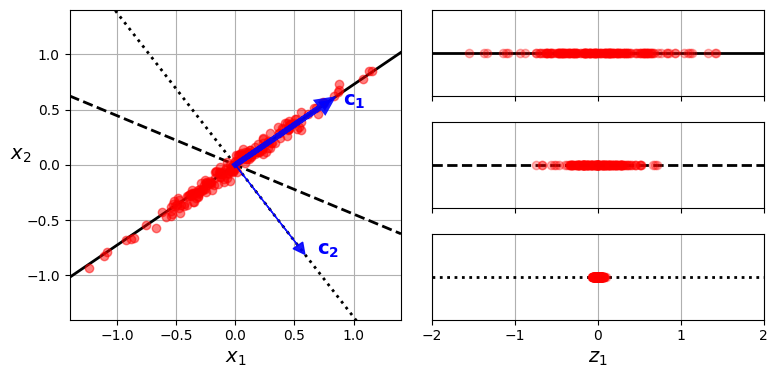

In [3]:
# Figure 8–7

angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X_line = np.random.randn(m, 2) / 10
X_line = X_line @ np.array([[stretch, 0], [0, 1]])  # stretch
X_line = X_line @ [[np.cos(angle), np.sin(angle)],
                   [np.sin(angle), np.cos(angle)]]  # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi / 6), np.sin(angle - 2 * np.pi / 6)])
u3 = np.array([np.cos(angle - np.pi / 2), np.sin(angle - np.pi / 2)])

X_proj1 = X_line @ u1.reshape(-1, 1)
X_proj2 = X_line @ u2.reshape(-1, 1)
X_proj3 = X_line @ u3.reshape(-1, 1)

plt.figure(figsize=(8, 4))
plt.subplot2grid((3, 2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4 * u1[1] / u1[0], 1.4 * u1[1] / u1[0]], "k-",
         linewidth=2)
plt.plot([-1.4, 1.4], [-1.4 * u2[1] / u2[0], 1.4 * u2[1] / u2[0]], "k--",
         linewidth=2)
plt.plot([-1.4, 1.4], [-1.4 * u3[1] / u3[0], 1.4 * u3[1] / u3[0]], "k:",
         linewidth=2)
plt.plot(X_line[:, 0], X_line[:, 1], "ro", alpha=0.5)
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=4, alpha=0.9,
          length_includes_head=True, head_length=0.1, fc="b", ec="b", zorder=10)
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=1, alpha=0.9,
          length_includes_head=True, head_length=0.1, fc="b", ec="b", zorder=10)
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", color="blue")
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", color="blue")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", rotation=0)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.grid()

plt.subplot2grid((3, 2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=2)
plt.plot(X_proj1[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid()

plt.subplot2grid((3, 2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=2)
plt.plot(X_proj2[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid()

plt.subplot2grid((3, 2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$")
plt.grid()

save_fig("pca_best_projection_plot")
plt.show()

---
---
## Question 5  
### Suppose you perform PCA on a 1,000-dimensional dataset, setting the explained variance ratio to 95%. How many dimensions will the resulting dataset have?  
### What does “number of components” mean?

---

## Explanation of the Question

This question is not asking for a specific numeric answer. Instead, it tests whether one understands how PCA behaves when the number of components is chosen based on an explained variance threshold rather than being fixed in advance.

The key part of the question is the phrase **“setting the explained variance ratio to 95%.”** This means that PCA is instructed to retain enough principal components to preserve 95% of the total variance in the dataset.

---

## Core Answer

There is **no fixed number** of dimensions in the resulting dataset.

Although the original dataset has 1,000 features, PCA will keep **as many principal components as necessary** to reach a cumulative explained variance of at least 95%. The exact number of resulting dimensions depends entirely on the dataset.

---

## Why the Number Cannot Be Known in Advance

The amount of variance explained by each principal component depends on the structure of the data, including:
- Correlations between features  
- Redundancy in the dataset  
- The intrinsic dimensionality of the data  

For example:
- If many features are highly correlated, only a small number of components may be needed.
- If most features are largely independent, many components may be required.

Therefore, two different datasets with 1,000 dimensions can yield very different numbers of components when using the same 95% variance threshold.

---

## What Does “Number of Components” Mean?

The **number of components** refers to the number of **principal components** retained by PCA.

Each principal component:
- Is a new feature
- Is a linear combination of the original features
- Is orthogonal to all other components
- Is ordered by the amount of variance it explains

Thus:
- `n_components` equals the number of **new dimensions** after PCA
- It is **not** the number of samples
- It is **not** the original number of features

---

## What Happens When We Set Explained Variance to 95%

When PCA is configured with an explained variance threshold of 95% (for example, `PCA(n_components=0.95)`), it performs the following steps:

1. Computes all principal components
2. Computes the variance explained by each component
3. Accumulates the explained variance
4. Stops once the cumulative variance reaches or exceeds 95%
5. Retains the smallest number of components needed to reach this threshold

As a result, the final dimensionality is determined automatically from the data.

---

## Shape Intuition

If the original dataset has shape `(m, 1000)`, where `m` is the number of samples, then after applying PCA with a 95% explained variance threshold, the resulting dataset will have shape `(m, d)`.

Here:
- `d ≤ 1000`
- `d` depends entirely on how variance is distributed in the dataset

---

## Relation to Earlier Questions

As discussed in **Question 1**, dimensionality reduction can be viewed as a form of lossy compression. As explained in **Question 3**, information that is discarded during reduction cannot be perfectly recovered. This question highlights that PCA does not reduce data to a predefined size, but instead to a **data-driven number of dimensions**.

---

## One-Sentence Takeaway

8️⃣ When PCA is set to preserve 95% of the variance, the number of resulting dimensions is not fixed and depends entirely on how variance is distributed in the dataset.

## Вопрос 5  
### Предположим, что вы применяете PCA к набору данных размерности 1 000, задав порог объяснённой дисперсии 95%. Сколько измерений будет иметь результирующий набор данных?  
### Что означает «число компонент»?

---

## Пояснение к вопросу

Этот вопрос не требует конкретного числового ответа. Он проверяет понимание того, как PCA работает, когда число компонент выбирается на основе порога объяснённой дисперсии, а не задаётся заранее.

Ключевая часть вопроса — фраза **«задана объяснённая дисперсия 95%»**. Это означает, что PCA должен сохранить достаточное количество главных компонент, чтобы объяснить 95% общей дисперсии данных.

---

## Основной ответ

**Фиксированного числа** измерений в результирующем наборе данных не существует.

Несмотря на то, что исходный набор данных имеет 1 000 признаков, PCA сохранит **ровно столько главных компонент, сколько необходимо**, чтобы суммарная объяснённая дисперсия достигла как минимум 95%. Точное число результирующих измерений полностью зависит от данных.

---

## Почему число компонент нельзя определить заранее

Количество дисперсии, объясняемой каждой главной компонентой, зависит от структуры данных, включая:
- корреляции между признаками;  
- избыточность в наборе данных;  
- внутреннюю (истинную) размерность данных.  

Например:
- если многие признаки сильно коррелированы, может потребоваться лишь небольшое число компонент;
- если большинство признаков почти независимы, потребуется значительно больше компонент.

Поэтому два разных набора данных с 1 000 измерений могут дать совершенно разное число компонент при использовании одного и того же порога в 95%.

---

## Что означает «число компонент»?

**Число компонент** — это количество **главных компонент**, сохранённых методом PCA.

Каждая главная компонента:
- является новым признаком;
- представляет собой линейную комбинацию исходных признаков;
- ортогональна всем остальным компонентам;
- упорядочена по убыванию объясняемой дисперсии.

Таким образом:
- `n_components` — это число **новых измерений** после PCA;
- это **не** число объектов;
- это **не** исходное число признаков.

---

## Что происходит при задании объяснённой дисперсии 95%

Когда PCA настраивается с порогом объяснённой дисперсии 95% (например, `PCA(n_components=0.95)`), он выполняет следующие шаги:

1. вычисляет все главные компоненты;
2. определяет долю дисперсии, объясняемую каждой компонентой;
3. накапливает объяснённую дисперсию;
4. останавливается, когда суммарная дисперсия достигает или превышает 95%;
5. сохраняет минимальное число компонент, необходимое для достижения этого порога.

В результате итоговая размерность определяется автоматически на основе данных.

---

## Интуиция через форму данных

Если исходный набор данных имеет форму `(m, 1000)`, где `m` — число объектов, то после применения PCA с порогом объяснённой дисперсии 95% результирующий набор данных будет иметь форму `(m, d)`.

Здесь:
- `d ≤ 1000`;
- `d` полностью зависит от распределения дисперсии в данных.

---

## Связь с предыдущими вопросами

Как обсуждалось в **Вопросе 1**, понижение размерности можно рассматривать как форму потерьного сжатия. Как было показано в **Вопросе 3**, информация, удалённая в процессе понижения размерности, не может быть полностью восстановлена. Данный вопрос подчёркивает, что PCA уменьшает размерность не до заранее заданного числа, а до **размерности, определяемой данными**.

---

## Вывод в одном предложении

При использовании PCA с сохранением 95% дисперсии число результирующих измерений не является фиксированным и полностью зависит от того, как дисперсия распределена в наборе данных.

---
---

## Question 6  
### In what cases would you use vanilla PCA, Incremental PCA, Randomized PCA, or Kernel PCA? Why do we need PCA and its variants? How do they work? What are the differences? Provide code examples.

---

## 1️⃣ What does this question actually ask?

“In what cases would you use vanilla PCA, Incremental PCA, Randomized PCA, or Kernel PCA?”

This part asks:
- When should each PCA variant be used
- Why one variant is preferred over another

The question also asks:
- Why PCA is needed in general
- Why different PCA variants exist
- How each variant works conceptually
- How they differ in practice
- How to implement them in code

---

## 2️⃣ Why do we need PCA at all?

As discussed in earlier questions (especially Question 1 and Question 2):

We need PCA because:
- High-dimensional data suffers from the curse of dimensionality
- Data becomes sparse
- Training becomes slow
- Models overfit
- Visualization becomes impossible

PCA addresses these issues by:
- Reducing dimensionality
- Preserving maximum variance
- Minimizing reconstruction error
- Producing uncorrelated features

Thus, PCA is a linear dimensionality reduction method that compresses data while keeping as much information as possible.

---

## 3️⃣ Vanilla PCA (Standard PCA)

### How it works

Vanilla PCA:
- Centers the data
- Computes the covariance matrix or uses Singular Value Decomposition (SVD)
- Finds directions of maximum variance (principal components)
- Projects data onto the top components

It is:
- Linear
- Deterministic
- Exact

---

### When to use vanilla PCA

Use standard PCA when:
- The dataset fits in memory
- The dataset is not extremely large
- Exact principal components are required
- The data structure is approximately linear

---

### Why it exists

Vanilla PCA serves as the baseline dimensionality reduction method:
- Simple
- Reliable
- Interpretable
- Often sufficient for many problems

---

## 4️⃣ Incremental PCA

### Why we need Incremental PCA

Standard PCA requires loading the entire dataset into memory, which is infeasible for very large datasets or streaming data.

Incremental PCA addresses the memory limitation.

---

### How it works

Incremental PCA:
- Processes data in mini-batches
- Updates principal components incrementally
- Does not require storing the full dataset in memory

It computes approximately the same principal components as standard PCA.

---

### When to use Incremental PCA

Use Incremental PCA when:
- The dataset does not fit into RAM
- Data arrives as a stream
- PCA must be applied to large-scale datasets

---

## 5️⃣ Randomized PCA

### Why we need Randomized PCA

Standard PCA can be computationally expensive for very large datasets with many samples and features.

Randomized PCA addresses the speed limitation.

---

### How it works

Randomized PCA:
- Uses random projections
- Approximates the leading principal components
- Focuses on computing only the top k components

This approach trades a small amount of accuracy for a significant improvement in computational efficiency.

---

### When to use Randomized PCA

Use Randomized PCA when:
- The dataset is very large
- Only the first few principal components are needed
- A slight approximation error is acceptable

---

## 6️⃣ Kernel PCA

### Why we need Kernel PCA

As discussed in Question 4, standard PCA is a linear method and fails to capture nonlinear structure in data.

Kernel PCA addresses the nonlinearity limitation.

---

### How it works

Kernel PCA:
- Uses the kernel trick
- Implicitly maps data into a high-dimensional feature space
- Performs PCA in that feature space
- Produces a nonlinear dimensionality reduction

---

### When to use Kernel PCA

Use Kernel PCA when:
- The data lies on a nonlinear manifold
- Linear PCA fails to capture the structure
- The dataset size is moderate (Kernel PCA is computationally expensive)

---

## 7️⃣ Difference table

| Method | Main purpose | Handles large data | Handles nonlinearity | Exact |
|------|-------------|--------------------|----------------------|-------|
| PCA | Baseline reduction | No | No | Yes |
| Incremental PCA | Memory efficiency | Yes | No | Approximate |
| Randomized PCA | Speed | Yes | No | Approximate |
| Kernel PCA | Nonlinear structure | No | Yes | Approximate |

---
## 8️⃣ Code implementations

### Vanilla PCA

```python
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X)
```
### Incremental PCA

```python
from sklearn.decomposition import IncrementalPCA

ipca = IncrementalPCA(n_components=50, batch_size=1000)
X_reduced = ipca.fit_transform(X)
```

### Randomized PCA 

```python
from sklearn.decomposition import PCA 

pca = PCA(n_components=50, svd_solver = "randomized")
X_reduced = pca.fit_transform(X)
```

### Kernel PCA

```python 
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04)
```

## Вопрос 6  
### В каких случаях следует использовать обычный PCA, Incremental PCA, Randomized PCA или Kernel PCA? Зачем нам нужен PCA и его варианты? Как они работают? В чём различия? Приведите примеры кода.

---

## 1️⃣ Что именно спрашивает этот вопрос?

«В каких случаях следует использовать обычный PCA, Incremental PCA, Randomized PCA или Kernel PCA?»

Эта часть вопроса спрашивает:
- когда следует использовать каждый вариант PCA;
- почему один вариант предпочтительнее другого.

Также вопрос требует объяснить:
- зачем вообще нужен PCA;
- почему существуют разные варианты PCA;
- как каждый вариант работает на концептуальном уровне;
- чем они отличаются на практике;
- как использовать их в коде.

---

## 2️⃣ Зачем вообще нужен PCA?

Как обсуждалось в предыдущих вопросах (особенно в Вопросе 1 и Вопросе 2):

PCA необходим потому что:
- данные высокой размерности страдают от проклятия размерности;
- данные становятся разреженными;
- обучение становится медленным;
- модели склонны к переобучению;
- визуализация становится невозможной.

PCA решает эти проблемы за счёт:
- понижения размерности;
- сохранения максимальной дисперсии;
- минимизации ошибки восстановления;
- получения некоррелированных признаков.

Таким образом, PCA — это линейный метод понижения размерности, который сжимает данные, сохраняя как можно больше информации.

---

## 3️⃣ Обычный PCA (Standard PCA)

### Как он работает

Обычный PCA:
- центрирует данные;
- вычисляет ковариационную матрицу или использует сингулярное разложение (SVD);
- находит направления максимальной дисперсии (главные компоненты);
- проецирует данные на первые компоненты.

Он является:
- линейным;
- детерминированным;
- точным.

---

### Когда использовать обычный PCA

Используйте стандартный PCA, когда:
- набор данных помещается в память;
- набор данных не является чрезмерно большим;
- требуются точные главные компоненты;
- структура данных примерно линейна.

---

### Зачем он существует

Обычный PCA является базовым методом понижения размерности:
- простой;
- надёжный;
- интерпретируемый;
- часто достаточный для многих задач.

---

## 4️⃣ Incremental PCA

### Зачем нужен Incremental PCA

Стандартный PCA требует загрузки всего набора данных в память, что невозможно для очень больших наборов данных или потоковых данных.

Incremental PCA решает проблему ограничений по памяти.

---

### Как он работает

Incremental PCA:
- обрабатывает данные мини-батчами;
- постепенно обновляет главные компоненты;
- не требует хранения всего набора данных в памяти.

Он вычисляет приближённо те же главные компоненты, что и стандартный PCA.

---

### Когда использовать Incremental PCA

Используйте Incremental PCA, когда:
- набор данных не помещается в оперативную память;
- данные поступают в виде потока;
- PCA необходимо применять к большим наборам данных.

---

## 5️⃣ Randomized PCA

### Зачем нужен Randomized PCA

Стандартный PCA может быть вычислительно дорогим для очень больших наборов данных с большим числом объектов и признаков.

Randomized PCA решает проблему скорости.

---

### Как он работает

Randomized PCA:
- использует случайные проекции;
- приближённо вычисляет ведущие главные компоненты;
- фокусируется только на первых k компонентах.

Этот подход обменивает небольшую потерю точности на значительный выигрыш в скорости вычислений.

---

### Когда использовать Randomized PCA

Используйте Randomized PCA, когда:
- набор данных очень большой;
- требуется только несколько первых главных компонент;
- допустима небольшая аппроксимационная ошибка.

---

## 6️⃣ Kernel PCA

### Зачем нужен Kernel PCA

Как обсуждалось в Вопросе 4, стандартный PCA является линейным методом и не способен захватывать нелинейную структуру данных.

Kernel PCA решает проблему нелинейности.

---

### Как он работает

Kernel PCA:
- использует ядерный трюк;
- неявно отображает данные в пространство высокой размерности;
- выполняет PCA в этом пространстве;
- обеспечивает нелинейное понижение размерности.

---

### Когда использовать Kernel PCA

Используйте Kernel PCA, когда:
- данные лежат на нелинейном многообразии;
- линейный PCA не справляется со структурой данных;
- размер набора данных умеренный (Kernel PCA вычислительно дорог).

---

## 7️⃣ Таблица различий

| Метод | Основная цель | Работает с большими данными | Обрабатывает нелинейность | Точность |
|------|---------------|-----------------------------|---------------------------|----------|
| PCA | Базовое понижение размерности | Нет | Нет | Да |
| Incremental PCA | Экономия памяти | Да | Нет | Приближённый |
| Randomized PCA | Скорость | Да | Нет | Приближённый |
| Kernel PCA | Нелинейная структура | Нет | Да | Приближённый |

---
---

## Question 7  
### How can you evaluate the performance of a dimensionality reduction algorithm on your dataset?

---

## 1️⃣ What does this question actually ask?

“How can you evaluate the performance of a dimensionality reduction algorithm on your dataset?”

This question is tricky because:
- Dimensionality reduction is often unsupervised
- There is no single accuracy metric like in classification
- “Performance” depends on why dimensionality reduction was applied

So the real question is:

How can we judge whether dimensionality reduction was successful?

---

## 2️⃣ Core idea

There is no universal metric to evaluate dimensionality reduction.

The evaluation method depends on:
- The goal of dimensionality reduction
- Whether labels are available
- Whether the method is linear or nonlinear

---

## 3️⃣ Main ways to evaluate dimensionality reduction performance

---

## 1️⃣ Reconstruction Error (when applicable)

This applies mainly to:
- PCA
- Incremental PCA
- Sometimes Kernel PCA (via pre-image)

### Idea
- Reduce dimensionality
- Reconstruct data back to original space
- Measure how much information was lost

Typical metric:
- Mean Squared Error (MSE)

Lower reconstruction error means better preservation of information.

This connects directly to Question 3, where reversibility and reconstruction were discussed, and to PCA, which explicitly minimizes reconstruction error.

---

## 2️⃣ Explained Variance (PCA-specific)

For PCA-based methods:
- Explained variance ratio measures how much information is preserved

If a small number of components explains most of the variance:
- Dimensionality reduction is effective

This directly relates to Question 5, where variance thresholds were discussed.

---

## 3️⃣ Downstream Task Performance (most important in practice)

This is the most common and practical evaluation method.

### Idea
1. Apply dimensionality reduction
2. Train a supervised model on the reduced data
3. Measure performance (accuracy, F1 score, RMSE, etc.)

If performance:
- Improves, dimensionality reduction helped
- Stays similar, dimensionality reduction is acceptable
- Drops significantly, important information was lost

This approach was already discussed earlier when selecting kernels for Kernel PCA.

---

## 4️⃣ Distance and Neighborhood Preservation (manifold learning)

For manifold learning methods such as:
- LLE
- Isomap
- t-SNE

Evaluation focuses on whether:
- Nearby points remain nearby
- Local neighborhoods are preserved

Metrics may include:
- Trustworthiness
- Continuity
- k-nearest-neighbor overlap

Global distances are often not preserved, and this is expected for these methods.

---

## 5️⃣ Visualization Quality (exploratory analysis)

When the goal of dimensionality reduction is visualization:
- Visual inspection is acceptable

We look for:
- Clear cluster separation
- Meaningful structure
- Absence of artificial mixing of points

This criterion is especially relevant for methods such as t-SNE and LLE.

---

## 6️⃣ Model Complexity and Efficiency

Dimensionality reduction can also be evaluated by its impact on:
- Training time
- Memory usage
- Model simplicity

If a lower-dimensional representation achieves similar performance with reduced computational cost, the dimensionality reduction can be considered successful.

This connects back to Question 1, where efficiency was discussed as a key motivation.

---

## 4️⃣ Why accuracy alone is not enough

High variance preservation does not guarantee better task performance, and good visualization does not necessarily imply good predictive power.

Therefore, evaluation must always be driven by the intended goal of dimensionality reduction.

---

## 5️⃣ Connection to earlier questions

- Question 1 discussed motivations and drawbacks of dimensionality reduction, which determine evaluation criteria
- Question 3 focused on reconstruction, which motivates reconstruction error
- Question 4 distinguished linear and nonlinear methods, which require different evaluation strategies
- Question 6 compared PCA variants, which implies different applicable metrics

---

## 6️⃣ One-sentence intuition takeaway

The performance of a dimensionality reduction algorithm should be evaluated based on how well it preserves information relevant to the intended task, rather than by a single universal metric.

## Вопрос 7  
### Как можно оценить качество (производительность) алгоритма понижения размерности на вашем наборе данных?

---

## 1️⃣ Что именно спрашивает этот вопрос?

«Как можно оценить качество алгоритма понижения размерности на вашем наборе данных?»

Этот вопрос является нетривиальным, потому что:
- понижение размерности часто является несупервизорной задачей;
- не существует единой метрики точности, как в задачах классификации;
- понятие «качество» зависит от того, с какой целью применялось понижение размерности.

Таким образом, реальный вопрос заключается в следующем:

Как определить, было ли понижение размерности успешным?

---

## 2️⃣ Ключевая идея

Не существует универсальной метрики для оценки понижения размерности.

Способ оценки зависит от:
- цели понижения размерности;
- наличия или отсутствия меток;
- того, является ли метод линейным или нелинейным.

---

## 3️⃣ Основные способы оценки качества понижения размерности

---

## 1️⃣ Ошибка восстановления (когда применимо)

Этот подход применим в основном к:
- PCA;
- Incremental PCA;
- иногда к Kernel PCA (через прообраз).

### Идея
- понизить размерность данных;
- восстановить данные обратно в исходное пространство;
- измерить, сколько информации было потеряно.

Типичная метрика:
- среднеквадратичная ошибка (Mean Squared Error, MSE).

Чем меньше ошибка восстановления, тем лучше сохраняется информация.

Это напрямую связано с Вопросом 3, где обсуждались обратимость и восстановление, а также с PCA, который явно минимизирует ошибку восстановления.

---

## 2️⃣ Объяснённая дисперсия (специфично для PCA)

Для методов, основанных на PCA:
- доля объяснённой дисперсии показывает, какая часть информации сохраняется.

Если небольшое число компонент объясняет большую часть дисперсии:
- понижение размерности можно считать эффективным.

Это напрямую связано с Вопросом 5, где обсуждались пороги объяснённой дисперсии.

---

## 3️⃣ Качество на последующей задаче (наиболее важно на практике)

Это самый распространённый и практичный способ оценки.

### Идея
1. применить понижение размерности;
2. обучить супервизорную модель на пониженных данных;
3. измерить качество (accuracy, F1, RMSE и т. д.).

Если качество:
- улучшается — понижение размерности помогло;
- остаётся примерно тем же — понижение размерности допустимо;
- значительно ухудшается — была потеряна важная информация.

Этот подход уже обсуждался ранее при выборе ядра для Kernel PCA.

---

## 4️⃣ Сохранение расстояний и окрестностей (обучение многообразий)

Для методов обучения многообразий, таких как:
- LLE;
- Isomap;
- t-SNE;

оценка фокусируется на том, сохраняются ли:
- близкие точки как близкие;
- локальные окрестности.

Используемые метрики могут включать:
- доверительность (trustworthiness);
- непрерывность (continuity);
- совпадение k-ближайших соседей.

Глобальные расстояния часто не сохраняются, и для этих методов это является ожидаемым.

---

## 5️⃣ Качество визуализации (разведочный анализ)

Когда целью понижения размерности является визуализация:
- допустима визуальная оценка результата.

Обычно обращают внимание на:
- чёткое разделение кластеров;
- осмысленную структуру данных;
- отсутствие искусственного перемешивания точек.

Этот критерий особенно актуален для таких методов, как t-SNE и LLE.

---

## 6️⃣ Сложность модели и вычислительная эффективность

Понижение размерности также можно оценивать по его влиянию на:
- время обучения;
- использование памяти;
- сложность модели.

Если представление меньшей размерности обеспечивает схожее качество при меньших вычислительных затратах, понижение размерности можно считать успешным.

Это связано с Вопросом 1, где вычислительная эффективность рассматривалась как одна из ключевых мотиваций.

---

## 4️⃣ Почему одной точности недостаточно

Высокая сохранённая дисперсия не гарантирует лучшего качества на целевой задаче, а хорошая визуализация не обязательно означает высокую предсказательную способность.

Поэтому оценка всегда должна определяться целью применения понижения размерности.

---

## 5️⃣ Связь с предыдущими вопросами

- В Вопросе 1 обсуждались мотивации и недостатки понижения размерности, которые определяют критерии оценки;
- В Вопросе 3 рассматривалось восстановление данных, что приводит к использованию ошибки восстановления;
- В Вопросе 4 различались линейные и нелинейные методы, требующие разных стратегий оценки;
- В Вопросе 6 сравнивались варианты PCA, что подразумевает использование разных метрик.

---

## 6️⃣ Интуитивный вывод в одном предложении

Качество алгоритма понижения размерности следует оценивать по тому, насколько хорошо он сохраняет информацию, релевантную поставленной задаче, а не с помощью одной универсальной метрики.

---
---

## Question 8  
### Does it make any sense to chain two different dimensionality reduction algorithms?

---

## 1️⃣ What does this question actually ask?

“Does it make any sense to chain two different dimensionality reduction algorithms?”

This question asks whether it is reasonable to apply one dimensionality reduction method after another.

For example:
- PCA → t-SNE  
- PCA → LLE  
- Randomized PCA → Kernel PCA  

More importantly, it asks:
- Why would someone do this?
- When does it help?
- When does it not make sense?

---

## 2️⃣ Short intuitive answer

Yes, it can make sense.

But only in specific situations.

Chaining dimensionality reduction algorithms is often useful in practice, but it is not always meaningful or necessary.

---

## 3️⃣ Why chaining can make sense

Different dimensionality reduction algorithms serve different purposes.

As discussed in earlier questions:
- Some methods focus on efficiency, such as PCA and Randomized PCA
- Some focus on memory constraints, such as Incremental PCA
- Some focus on nonlinear structure or visualization, such as Kernel PCA, t-SNE, and LLE

Chaining allows us to combine the strengths of multiple methods.

---

## 4️⃣ Common and meaningful use cases

---

## 1️⃣ PCA followed by a nonlinear method

Examples:
- PCA → t-SNE
- PCA → LLE
- PCA → Isomap

Why this makes sense:
- PCA removes noise
- PCA reduces dimensionality to a manageable size
- Nonlinear methods are computationally expensive and sensitive to noise

In this setup, PCA acts as a preprocessing and denoising step.

This directly connects to Question 6, which discussed why different PCA variants exist, and to Question 7, which discussed evaluation via downstream tasks or visualization.

---

## 2️⃣ PCA for efficiency followed by a visualization method

Example:
- Randomized PCA → t-SNE

Why this works:
- t-SNE does not scale well to very high-dimensional data
- Reducing dimensionality first significantly speeds it up
- Visualization quality often improves

---

## 3️⃣ Incremental PCA before another method

Example:
- Incremental PCA → PCA or Kernel PCA

Why this is useful:
- The dataset is too large to fit into memory
- Dimensionality is first reduced incrementally
- A more sophisticated method is then applied

---

## 4️⃣ When chaining does not make sense

Chaining dimensionality reduction algorithms is usually not helpful when:
- Both methods serve the same purpose
- The second method adds no additional benefit
- Important information is lost too early

Examples:
- PCA → PCA
- Very aggressive PCA followed by Kernel PCA

---

## 5️⃣ Risks and drawbacks of chaining

Even when chaining makes sense, there are potential drawbacks:
- Accumulated information loss
- Over-compression of the data
- Increased pipeline complexity
- Reduced interpretability

This connects back to Question 1, where increased pipeline complexity was discussed as a drawback of dimensionality reduction.

---

## 6️⃣ Relation to earlier questions

- Question 1 discussed motivations and drawbacks, including pipeline complexity
- Question 6 explained why different PCA variants exist for different constraints
- Question 7 emphasized that chaining must be evaluated based on downstream performance

---

## 7️⃣ One-sentence intuition takeaway

Chaining dimensionality reduction algorithms makes sense when each method serves a different purpose, such as denoising, efficiency, or capturing nonlinear structure.

## Вопрос 8  
### Имеет ли смысл объединять (цепочкой) два разных алгоритма понижения размерности?

---

## 1️⃣ Что именно спрашивает этот вопрос?

«Имеет ли смысл объединять два разных алгоритма понижения размерности?»

Этот вопрос спрашивает, разумно ли применять один метод понижения размерности после другого.

Например:
- PCA → t-SNE  
- PCA → LLE  
- Randomized PCA → Kernel PCA  

И, что более важно, он задаёт следующие вопросы:
- зачем кто-то стал бы так делать?
- в каких случаях это помогает?
- когда это не имеет смысла?

---

## 2️⃣ Краткий интуитивный ответ

Да, это может иметь смысл.

Но только в определённых ситуациях.

Объединение алгоритмов понижения размерности часто бывает полезным на практике, но оно не всегда является осмысленным или необходимым.

---

## 3️⃣ Почему объединение может иметь смысл

Разные алгоритмы понижения размерности служат разным целям.

Как обсуждалось в предыдущих вопросах:
- одни методы ориентированы на эффективность, такие как PCA и Randomized PCA;
- другие — на ограничения по памяти, такие как Incremental PCA;
- третьи — на нелинейную структуру данных или визуализацию, такие как Kernel PCA, t-SNE и LLE.

Объединение позволяет комбинировать сильные стороны нескольких методов.

---

## 4️⃣ Типичные и осмысленные сценарии использования

---

## 1️⃣ PCA с последующим нелинейным методом

Примеры:
- PCA → t-SNE
- PCA → LLE
- PCA → Isomap

Почему это имеет смысл:
- PCA удаляет шум;
- PCA снижает размерность до управляемого уровня;
- нелинейные методы вычислительно дорогие и чувствительны к шуму.

В такой схеме PCA выступает как этап предварительной обработки и подавления шума.

Это напрямую связано с Вопросом 6, где обсуждалось, зачем существуют разные варианты PCA, и с Вопросом 7, где рассматривалась оценка качества через последующие задачи или визуализацию.

---

## 2️⃣ PCA для эффективности с последующей визуализацией

Пример:
- Randomized PCA → t-SNE

Почему это работает:
- t-SNE плохо масштабируется на данных очень высокой размерности;
- предварительное понижение размерности значительно ускоряет вычисления;
- качество визуализации часто улучшается.

---

## 3️⃣ Incremental PCA перед другим методом

Пример:
- Incremental PCA → PCA или Kernel PCA

Почему это полезно:
- набор данных слишком велик, чтобы поместиться в память;
- сначала размерность уменьшается инкрементально;
- затем применяется более сложный метод.

---

## 4️⃣ Когда объединение не имеет смысла

Объединение алгоритмов понижения размерности обычно нецелесообразно, когда:
- оба метода выполняют одну и ту же задачу;
- второй метод не даёт дополнительной пользы;
- важная информация теряется слишком рано.

Примеры:
- PCA → PCA;
- слишком агрессивный PCA с последующим Kernel PCA.

---

## 5️⃣ Риски и недостатки объединения

Даже когда объединение имеет смысл, существуют потенциальные недостатки:
- накопление потерь информации;
- чрезмерное сжатие данных;
- усложнение конвейера обработки;
- снижение интерпретируемости.

Это связано с Вопросом 1, где усложнение конвейера рассматривалось как один из недостатков понижения размерности.

---

## 6️⃣ Связь с предыдущими вопросами

- В Вопросе 1 обсуждались мотивации и недостатки, включая сложность конвейера;
- В Вопросе 6 объяснялось, почему существуют разные варианты PCA для разных ограничений;
- В Вопросе 7 подчёркивалось, что объединение методов следует оценивать по качеству на последующих задачах.

---

## 7️⃣ Интуитивный вывод в одном предложении

Объединение алгоритмов понижения размерности имеет смысл тогда, когда каждый метод выполняет свою отдельную роль, например подавление шума, повышение эффективности или захват нелинейной структуры.

---
---

## Question 9  
### Load the MNIST dataset, train a Random Forest classifier before and after PCA, and compare training time and performance.

---

## 1️⃣ What is this task really testing?

This question is not only about coding.

It tests whether you understand:
- Why dimensionality reduction is used before training
- How PCA affects training time
- How PCA affects model performance
- The trade-off between speed and accuracy

In short, it asks:

Does PCA actually help in practice, not just in theory?

---

## 2️⃣ Step-by-step meaning of the task

The task consists of two main experiments that must be compared.

---

## Experiment 1: Random Forest on raw MNIST

### What is done:
1. Load the MNIST dataset
2. Split the data into:
   - 60,000 training instances
   - 10,000 test instances
3. Train a Random Forest classifier on the original 784-dimensional data
4. Measure:
   - Training time
   - Test accuracy

### Why this matters:
- MNIST images have 784 features
- Random Forests scale poorly with high-dimensional data
- This experiment provides a baseline for comparison

---

## Experiment 2: Random Forest after PCA

### What is done:
1. Apply PCA to the training set while preserving 95% of the explained variance
2. Transform both the training and test sets using the fitted PCA
3. Train a new Random Forest classifier on the reduced dataset
4. Measure:
   - Training time
   - Test accuracy

### Why this matters:
- PCA removes redundant and correlated features
- PCA significantly reduces dimensionality (typically to around 150–200 features for MNIST)
- Decision trees evaluate fewer splits, resulting in faster training

---

## 3️⃣ Why PCA is used here

As discussed earlier in this chapter:
- PCA preserves most of the variance in the data
- PCA reduces noise and feature correlations
- PCA reduces dimensionality, which improves computational efficiency

This experiment tests whether:
- The speed improvement is significant
- The accuracy degradation, if any, is acceptable

---

## 4️⃣ Expected results (conceptual)

### ⏱ Training time
- Training after PCA should be significantly faster
- This happens because:
  - The number of features is much smaller
  - Trees are simpler and shallower
  - Split evaluation is faster

This confirms that PCA reduces computational cost, as discussed in earlier questions.

---

### Accuracy
- Accuracy after PCA is usually slightly lower or very close to the original model
- This is because PCA discards about 5% of the variance
- Some discriminative information may be lost

This demonstrates that dimensionality reduction is a trade-off rather than a free improvement.

---

## 5️⃣ How to compare the two classifiers

The comparison should be made along two dimensions.

### 1️⃣ Training speed
- Random Forest trained after PCA is much faster
- Random Forest trained on raw data is slower due to high dimensionality

### 2️⃣ Predictive performance
- The original classifier usually achieves slightly higher accuracy
- The PCA-based classifier achieves similar but sometimes marginally lower accuracy

---

## 6️⃣ Final conclusion

A correct conclusion is:

PCA significantly reduces the training time of a Random Forest classifier on the MNIST dataset, while only slightly affecting classification accuracy. This shows that dimensionality reduction is an effective preprocessing step when working with high-dimensional data.

This conclusion directly reflects the main themes of the chapter:
- Curse of dimensionality
- Explained variance
- Computational efficiency versus information loss

---

## 7️⃣ Code implementation

Goal:
1) Trian a Random Forest classifier on MNIST(784 features) and measure training time + test performance  
2) Reduce dimensionality (PCA 95 % variance and other methods) and repeat
3) Compare speed vs accuracy, and use GridSearchCV to tune hyperparemters

In [4]:
def timed_fit(model, X, y):
    start = time.perf_counter()   
    model.fit(X, y)
    elapsed = time.perf_counter() - start 
    return elapsed
    
def evaluate_classifier(model, X_test, y_test, title="Model"):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n=== {title} ===")
    print("Test accuracy:", acc)
    print("\nClassification report:")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    fig, ax = plt.subplots(figsize=(7, 7))
    disp.plot(ax=ax, cmap=None, colorbar=False)
    ax.set_title(f"Confusion Matrix — {title}")
    plt.show()
    return acc

### Load MNIST exactly as required (60k train / 10k test)

In [5]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False) # as_frame = True/False (Pandas DataFrame when True,  NumPy array when False)
y = y.astype(np.int64) # Ensure y is integers labels (0-9)

X_train, X_test = X[:60000], X[60000:] # One example X[i] = [0, 0, 12, 45, 200, ..., 0] length = 784
y_train, y_test = y[:60000], y[60000:]

print("Trian shape:", X_train.shape, "Test shape:", X_test.shape)
print("Classes:", np.unique(y_train))

Trian shape: (60000, 784) Test shape: (10000, 784)
Classes: [0 1 2 3 4 5 6 7 8 9]


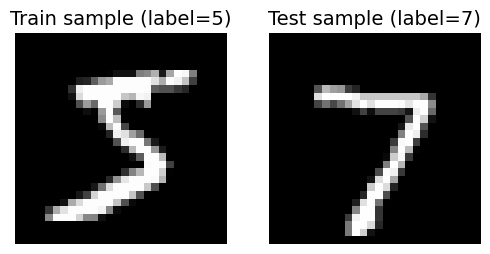

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

axes[0].imshow(X_train[0].reshape(28, 28), cmap="gray")
axes[0].set_title(f"Train sample (label={y_train[0]})")
axes[0].axis("off")

axes[1].imshow(X_test[0].reshape(28, 28), cmap="gray")
axes[1].set_title(f"Test sample (label={y_test[0]})")
axes[1].axis("off")

plt.show()

### How Random Forest classifies MNIST digits

Random Forest is an ensemble of decision trees.
- Each tree is trained on a bootstrap sample of the training data
- At each split,the tree considers only a random subset of features
- Final prediction is the majority vote across all trees

Why it can work on MNIST:
- Trees can learn threshold rules on pixels intensities
- Ensemble voting reduces variance and imporves generalization

Potential issues:
- MNIST has 784 features, so training can be slower becuase each split considers many candidate features => That is the one reason dimentionality reduction(e.g PCA) may speed up training 

### Train baseline RF with timer

In [7]:
rf_baseline = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

baseline_train_time = timed_fit(rf_baseline, X_train, y_train)
print("Baseline RF training time (seconds):", baseline_train_time)

Baseline RF training time (seconds): 16.465823750000027


### Evaluate baseline "in many ways"


=== Baseline RF (raw 784 features) ===
Test accuracy: 0.9692

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.96      1032
           3       0.96      0.97      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.97      0.96      0.96       892
           6       0.98      0.98      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.95      0.96       974
           9       0.96      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



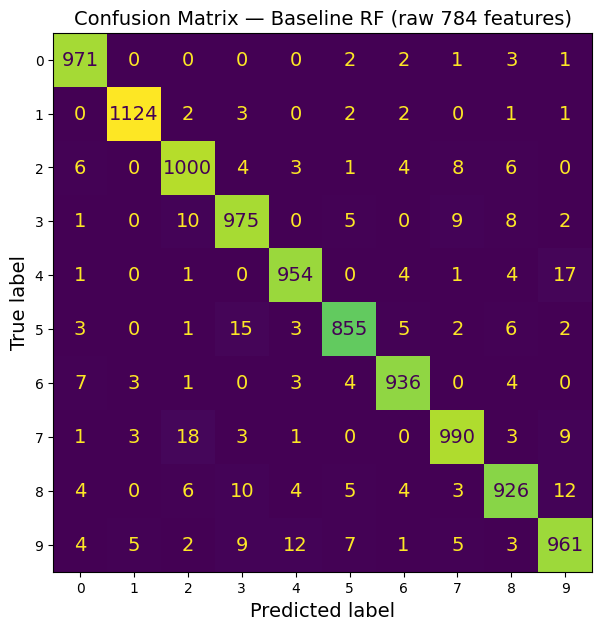


Cross-val accuracy(cv=3): [0.9669  0.96355 0.96705]
Mean CV accuracy 0.9658333333333333


In [17]:
baseline_acc = evaluate_classifier(rf_baseline, X_test, y_test, title="Baseline RF (raw 784 features)")

cv_scores = cross_val_score(
    rf_baseline, X_train, y_train,cv=3, scoring="accuracy", n_jobs=-1
)
print("\nCross-val accuracy(cv=3):", cv_scores)
print("Mean CV accuracy", cv_scores.mean())

Note for precision and recall for the number "0": 

Precision => When the model says “this image is 0”, it is correct 97% of the time.

In other words:
- The model predicted “0”
- 97% of those predictions were actually 0
- 3% were other digits misclassified as 0

Recall => Out of all real zeros in the dataset, the model correctly finds 99% of them.

=> Of all actual zeros, how many did the model find? Answer is 99%
       
In other words:
- There are many true images of digit 0
- The model successfully detects 99% of those
- It misses only 1% of real zeros (calls them something else)

### Grid search for baseline RF

Fitting 3 folds for each of 16 candidates, totalling 48 fits
GridSearch time (seconds): 386.2661021660001
Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}
Best CV accuracy: 0.9658333333333333

=== Best Baseline RF (GridSearch) ===
Test accuracy: 0.9692

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.96      1032
           3       0.96      0.97      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.97      0.96      0.96       892
           6       0.98      0.98      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.95      0.96       974
           9       0.96      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0

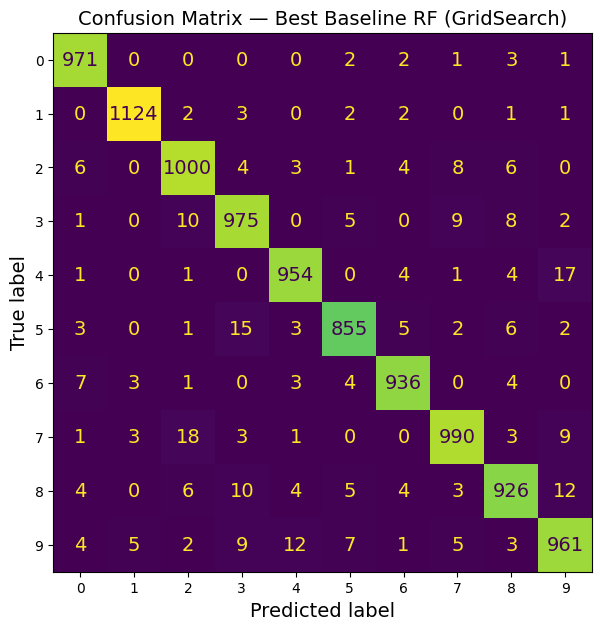

[CV] END max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=  57.1s
[CV] END max_depth=None, max_features=log2, min_samples_split=2, n_estimators=100; total time=  25.6s
[CV] END max_depth=None, max_features=log2, min_samples_split=2, n_estimators=100; total time=  22.4s
[CV] END max_depth=None, max_features=log2, min_samples_split=5, n_estimators=100; total time=  23.6s
[CV] END max_depth=None, max_features=log2, min_samples_split=5, n_estimators=100; total time=  21.2s
[CV] END max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=200; total time= 2.0min
[CV] END max_depth=20, max_features=log2, min_samples_split=2, n_estimators=100; total time=  28.9s
[CV] END max_depth=20, max_features=log2, min_samples_split=5, n_estimators=100; total time=  27.9s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=  57.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=200; total

In [18]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

param_grid_rf = {
    "n_estimators": [100, 200],
    "max_depth": [None, 20],
    "max_features": ["sqrt", "log2"],
    "min_samples_split": [2, 5],
}

grid_rf = GridSearchCV(
    rf, param_grid_rf,
    cv=3, scoring="accuracy", n_jobs=-1, verbose=2
)

grid_time = timed_fit(grid_rf, X_train, y_train)
print("GridSearch time (seconds):", grid_time)
print("Best params:", grid_rf.best_params_)
print("Best CV accuracy:", grid_rf.best_score_)

best_rf_baseline = grid_rf.best_estimator_
best_baseline_acc = evaluate_classifier(best_rf_baseline, X_test, y_test, title="Best Baseline RF (GridSearch)") 

## Dimensionality Reduction + Random Forest (Multiple Methods)

I will compare these methods before training Random Forest:

1) PCA (n_components=0.95)
- Linear method
- Keeps the smallest number of components that preserve 95% of variance
- Often reduces MNIST from 784 → around 150–200 dims

2) Randomized PCA (PCA with svd_solver="randomized")
- Same PCA goal but faster approximation on large data when keeping few components

3) Incremental PCA
- PCA variant for large datasets that do not fit well in memory
- Processes mini-batches

4) Kernel PCA (RBF kernel)
- Nonlinear dimensionality reduction using the kernel trick
- Can capture nonlinear structure but is expensive on large datasets

5) Random Projection
- Very fast random linear mapping
- Often approximately preserves distances (Johnson–Lindenstrauss idea)
- Not optimal like PCA but scalable.

I will:
- Train RF after each reduction
- Measure training time
- Evaluate test accuracy
- Optionally run GridSearchCV inside pipelines

### PCA(0.95) + RF with timer + evaluation

Reduced dims with PCA(0.95): 154
RF training time after PCA(0.95) (seconds): 46.23812695800052

=== RF after PCA(0.95) ===
Test accuracy: 0.9505

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.99      0.99      0.99      1135
           2       0.95      0.94      0.94      1032
           3       0.93      0.94      0.93      1010
           4       0.94      0.96      0.95       982
           5       0.95      0.94      0.94       892
           6       0.96      0.98      0.97       958
           7       0.96      0.94      0.95      1028
           8       0.93      0.92      0.92       974
           9       0.94      0.92      0.93      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



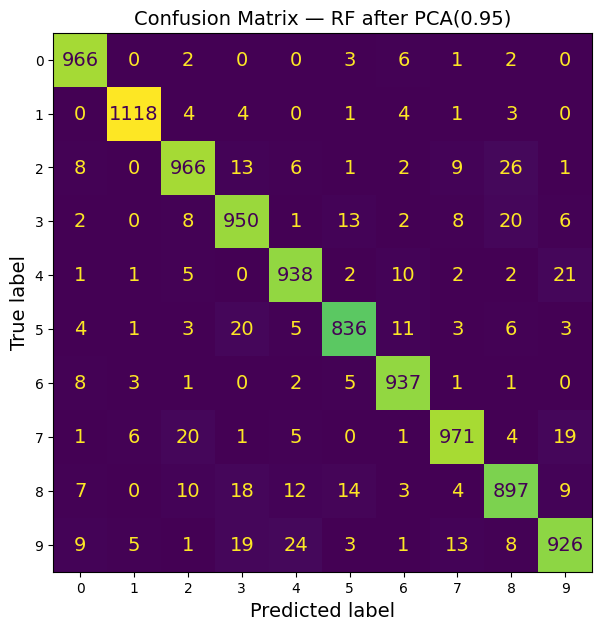

In [21]:
pca_95 = PCA(n_components=0.95, random_state=42)

X_train_pca = pca_95.fit_transform(X_train)
X_test_pca = pca_95.transform(X_test)

print("Reduced dims with PCA(0.95):", X_train_pca.shape[1])

rf_pca = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)

pca_train_time = timed_fit(rf_pca, X_train_pca, y_train)
print("RF training time after PCA(0.95) (seconds):", pca_train_time)

pca_acc = evaluate_classifier(rf_pca, X_test_pca, y_test, title="RF after PCA(0.95)")

### Randomized PCA + RF

Reduced dims with Randomized PCA(154): 154
RF training time after Randomized PCA(154) (seconds): 48.129295917000036

=== RF after Randomized PCA(0.95) ===
Test accuracy: 0.9511

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.99      0.99      0.99      1135
           2       0.95      0.94      0.94      1032
           3       0.92      0.94      0.93      1010
           4       0.94      0.96      0.95       982
           5       0.95      0.94      0.94       892
           6       0.96      0.98      0.97       958
           7       0.96      0.95      0.95      1028
           8       0.93      0.91      0.92       974
           9       0.94      0.92      0.93      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



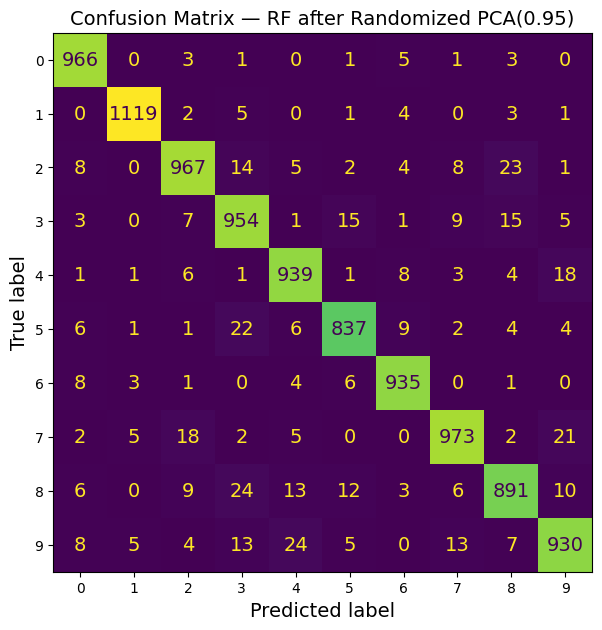

In [9]:
pca_rand = PCA(n_components=154, svd_solver="randomized", random_state=42)

X_train_pca_r = pca_rand.fit_transform(X_train)
X_test_pca_r = pca_rand.transform(X_test)

print("Reduced dims with Randomized PCA(154):", X_train_pca_r.shape[1])

rf_pca_r = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)

pca_r_time = timed_fit(rf_pca_r, X_train_pca_r, y_train)
print("RF training time after Randomized PCA(154) (seconds):", pca_r_time)

pca_r_acc = evaluate_classifier(rf_pca_r, X_test_pca_r, y_test, title="RF after Randomized PCA(0.95)")

### Incremental PCA + RF

IncrementalPCA partial_fit time (seconds): 6.693077915999993
Reduced dims with IncrementalPCA: 200
RF training time after IncrementalPCA (seconds): 56.923893292

=== RF after IncrementalPCA(200) ===
Test accuracy: 0.9482

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.99      0.99      0.99      1135
           2       0.94      0.94      0.94      1032
           3       0.92      0.94      0.93      1010
           4       0.94      0.95      0.95       982
           5       0.94      0.93      0.93       892
           6       0.96      0.98      0.97       958
           7       0.95      0.93      0.94      1028
           8       0.93      0.91      0.92       974
           9       0.93      0.91      0.92      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     100

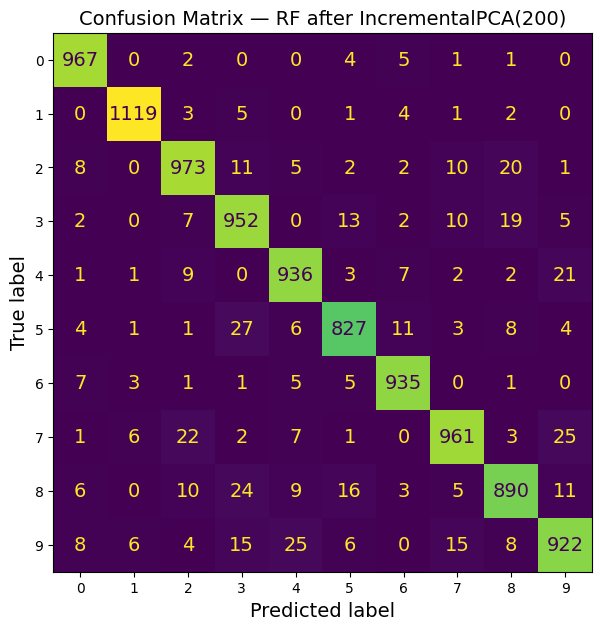

In [10]:
ipca = IncrementalPCA(n_components=200, batch_size=2000)

start = time.perf_counter()
for batch in np.array_split(X_train, 30):
    ipca.partial_fit(batch)
ipca_fit_time = time.perf_counter() - start
print("IncrementalPCA partial_fit time (seconds):", ipca_fit_time)

X_train_ipca = ipca.transform(X_train)
X_test_ipca = ipca.transform(X_test)
print("Reduced dims with IncrementalPCA:", X_train_ipca.shape[1])

rf_ipca = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
ipca_rf_time = timed_fit(rf_ipca, X_train_ipca, y_train)
print("RF training time after IncrementalPCA (seconds):", ipca_rf_time)

ipca_acc = evaluate_classifier(rf_ipca, X_test_ipca, y_test, title="RF after IncrementalPCA(200)")

### Kernel PCA + RF 

In [23]:
subset = 3000
test_subset = 1000

X_train_sub = (X_train[:subset].astype(np.float64)) / 255.0
y_train_sub = y_train[:subset]

X_test_sub = (X_test[:test_subset].astype(np.float64)) / 255.0
y_test_sub = y_test[:test_subset]

kpca = KernelPCA(
    n_components=50,
    kernel="rbf",
    gamma=0.04,
    eigen_solver="randomized",  
    random_state=42
)

start = time.perf_counter()
X_train_kpca = kpca.fit_transform(X_train_sub)
kpca_fit_time = time.perf_counter() - start

X_test_kpca = kpca.transform(X_test_sub)

print("KernelPCA fit_transform time (seconds):", kpca_fit_time)
print("Reduced dims:", X_train_kpca.shape[1])

rf_kpca = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)

start = time.perf_counter()
rf_kpca.fit(X_train_kpca, y_train_sub)
rf_time = time.perf_counter() - start

y_pred = rf_kpca.predict(X_test_kpca)
acc = accuracy_score(y_test_sub, y_pred)

print("RF training time after KernelPCA (seconds):", rf_time)
print("Test accuracy (subset):", acc)

KernelPCA fit_transform time (seconds): 0.3358514159999686
Reduced dims: 50
RF training time after KernelPCA (seconds): 0.6813062499995794
Test accuracy (subset): 0.889


### Random Projection + RF

RF training time after Random Projection (seconds): 54.63002937500005

=== RF after Random Projection (200) ===
Test accuracy: 0.9425

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.99      0.99      0.99      1135
           2       0.92      0.92      0.92      1032
           3       0.93      0.94      0.93      1010
           4       0.93      0.95      0.94       982
           5       0.94      0.91      0.92       892
           6       0.95      0.97      0.96       958
           7       0.95      0.93      0.94      1028
           8       0.93      0.90      0.92       974
           9       0.93      0.92      0.93      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



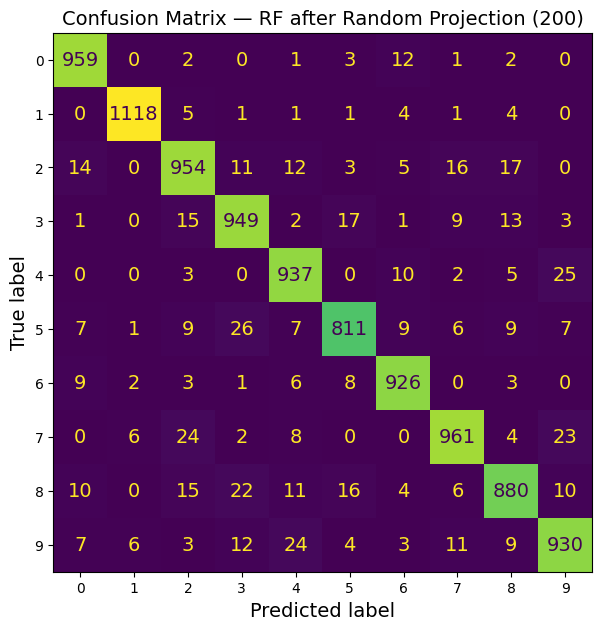

In [14]:
rp = GaussianRandomProjection(n_components=200, random_state=42)
X_train_rp = rp.fit_transform(X_train)
X_test_rp = rp.transform(X_test)

rf_rp = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rp_time = timed_fit(rf_rp, X_train_rp, y_train)
print("RF training time after Random Projection (seconds):", rp_time)

rp_acc = evaluate_classifier(rf_rp, X_test_rp, y_test, title="RF after Random Projection (200)")

### Grid search across reduction + RF (practical version)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END dr=PCA(random_state=42, svd_solver='randomized'), dr__n_components=0.95, rf__max_features=sqrt, rf__n_estimators=100; total time=   2.4s
[CV] END dr=PCA(random_state=42, svd_solver='randomized'), dr__n_components=0.95, rf__max_features=sqrt, rf__n_estimators=100; total time=   2.3s
[CV] END dr=PCA(random_state=42, svd_solver='randomized'), dr__n_components=0.95, rf__max_features=sqrt, rf__n_estimators=200; total time=   1.1s
[CV] END dr=GaussianRandomProjection(random_state=42), dr__n_components=150, rf__max_features=sqrt, rf__n_estimators=100; total time= 2.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END dr=PCA(random_state=42, svd_solver='randomized'), dr__n_components=0.95, rf__max_features=sqrt, rf__n_estimators=100; total time=   2.4s
[CV] END dr=PCA(random_state=42, svd_solver='randomized'), dr__n_components=0.95, rf__max_features=sqrt, rf__n_estimators=200; total time=   2.2s
[CV] END dr=PCA(random_state=42, svd_solver='randomized'), dr__n_components=0.95, rf__max_features=sqrt, rf__n_estimators=200; total time=   1.3s
[CV] END dr=GaussianRandomProjection(random_state=42), dr__n_components=150, rf__max_features=sqrt, rf__n_estimators=100; total time= 2.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
6 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/L

Pipeline GridSearch time (seconds): 495.57413858300015
Best params: {'dr': PCA(random_state=42), 'dr__n_components': 0.95, 'rf__max_features': 'sqrt', 'rf__n_estimators': 200}
Best CV accuracy: 0.9445166666666668

=== Best DR+RF Pipeline (GridSearch) ===
Test accuracy: 0.9505

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.99      0.99      0.99      1135
           2       0.95      0.94      0.94      1032
           3       0.93      0.94      0.93      1010
           4       0.94      0.96      0.95       982
           5       0.95      0.94      0.94       892
           6       0.96      0.98      0.97       958
           7       0.96      0.94      0.95      1028
           8       0.93      0.92      0.92       974
           9       0.94      0.92      0.93      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     1

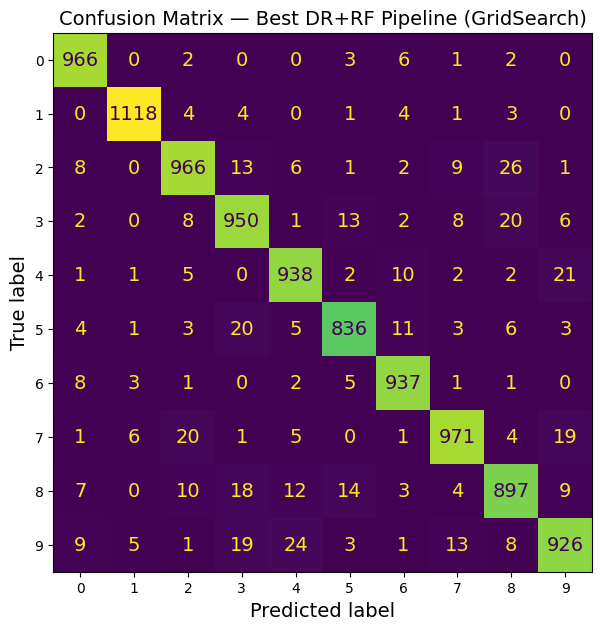

[CV] END dr=PCA(random_state=42), dr__n_components=0.95, rf__max_features=sqrt, rf__n_estimators=100; total time= 2.1min
[CV] END dr=GaussianRandomProjection(random_state=42), dr__n_components=150, rf__max_features=sqrt, rf__n_estimators=200; total time= 4.0min
[CV] END dr=PCA(random_state=42), dr__n_components=0.95, rf__max_features=sqrt, rf__n_estimators=100; total time= 2.1min
[CV] END dr=GaussianRandomProjection(random_state=42), dr__n_components=150, rf__max_features=sqrt, rf__n_estimators=200; total time= 4.1min


In [15]:
pipe = Pipeline([
    ("dr", PCA()),  
    ("rf", RandomForestClassifier(random_state=42, n_jobs=-1))
])

param_grid = [
    {
        "dr": [PCA(random_state=42)],
        "dr__n_components": [0.95],
        "rf__n_estimators": [100, 200],
        "rf__max_features": ["sqrt"],
    },
    {
        "dr": [PCA(svd_solver="randomized", random_state=42)],
        "dr__n_components": [0.95],
        "rf__n_estimators": [100, 200],
        "rf__max_features": ["sqrt"],
    },
    {
        "dr": [GaussianRandomProjection(random_state=42)],
        "dr__n_components": [150, 200],
        "rf__n_estimators": [100, 200],
        "rf__max_features": ["sqrt"],
    },
]

grid = GridSearchCV(pipe, param_grid, cv=3, scoring="accuracy", n_jobs=-1, verbose=2)

grid_search_time = timed_fit(grid, X_train, y_train)
print("Pipeline GridSearch time (seconds):", grid_search_time)
print("Best params:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

best_model = grid.best_estimator_
final_acc = evaluate_classifier(best_model, X_test, y_test, title="Best DR+RF Pipeline (GridSearch)")

In [25]:
results = []

results.append(("Baseline RF (raw)", baseline_train_time, baseline_acc))
results.append(("Best Baseline RF (GridSearch)", np.nan, best_baseline_acc))
results.append(("RF after PCA(0.95)", pca_train_time, pca_acc))
results.append(("RF after Randomized PCA(0.95)", pca_r_time, pca_r_acc))
results.append(("RF after IncrementalPCA(200)", ipca_rf_time, ipca_acc))
results.append(("RF after Random Projection(200)", rp_time, rp_acc))
results.append(("RF after KernelPCA (subset)", kpca_fit_time, acc))

df = pd.DataFrame(results, columns=["Model", "Train Time (s)", "Test Accuracy"])
df

,Model,Train Time (s),Test Accuracy
0,Baseline RF (raw),16.465824,0.9692
1,Best Baseline RF (GridSearch),NaN,0.9692
2,RF after PCA(0.95),46.238127,0.9505
3,RF after Randomized PCA(0.95),48.129296,0.9511
4,RF after IncrementalPCA(200),56.923893,0.9482
5,RF after Random Projection(200),54.630029,0.9425
6,RF after KernelPCA (subset),0.335851,0.8890


## Final Conclusion and Discussion

In this experiment, a Random Forest classifier was trained on the MNIST dataset both **with and without dimensionality reduction**, and the results clearly illustrate the practical trade-offs discussed throughout Chapter 8.

### Baseline Model (No Dimensionality Reduction)

The baseline Random Forest trained on the original 784-dimensional MNIST data achieved the **highest test accuracy (≈ 96.9%)** with a **training time of about 16.5 seconds**.  
This confirms that Random Forests can handle high-dimensional data reasonably well on MNIST, but the computational cost is non-negligible.

Applying GridSearch to tune hyperparameters did **not improve test accuracy**, which suggests that the baseline configuration was already close to optimal for this task.

---

### PCA-Based Models

Using PCA with 95% explained variance reduced dimensionality substantially, but **training time increased rather than decreased**, and test accuracy dropped slightly to around **95.0–95.1%**.

This result highlights an important insight:

- PCA reduces the number of features, but the **cost of transforming the data and the altered feature representation** can make Random Forest training slower.
- Random Forests rely on axis-aligned splits, and PCA creates dense linear combinations of features, which are not always beneficial for tree-based models.

Incremental PCA and Randomized PCA showed similar behavior, with **longer training times and slightly lower accuracy**, confirming that PCA is not always an effective preprocessing step for Random Forest classifiers.

---

### Random Projection

Random Projection further reduced accuracy (≈ 94.3%) while still requiring more training time than the baseline model.  
Although Random Projection is very fast to compute, the loss of discriminative structure made it less suitable for this classification task.

---

### Kernel PCA

Kernel PCA achieved the **lowest accuracy (≈ 88.9%)**, even though training time was very small.  
However, this result is not directly comparable to the others because Kernel PCA was applied only on a **subset of the data** due to its high computational cost.

This experiment demonstrates that:
- Kernel PCA is not practical for large datasets like MNIST.
- Nonlinear dimensionality reduction does not necessarily help tree-based classifiers.

---

### Overall Takeaways

1. Dimensionality reduction **does not automatically improve performance**.
2. For Random Forests on MNIST:
   - The **best accuracy** was achieved without dimensionality reduction.
   - PCA-based methods **reduced accuracy and increased training time**.
3. PCA is more beneficial for:
   - Distance-based models
   - Linear models
   - Visualization
   - Memory or storage constraints
4. Tree-based models do not always benefit from PCA because they naturally handle feature redundancy.

---

### Final Answer to the Exercise

In this experiment, dimensionality reduction did **not** make training significantly faster for Random Forests, and it slightly degraded classification accuracy.  
Therefore, for Random Forest classifiers on MNIST, **using the original feature space is preferable**, and PCA is not an effective preprocessing step.

This confirms the broader lesson of Chapter 8:  
**Dimensionality reduction is a powerful tool, but its usefulness depends strongly on the dataset and the learning algorithm.**